Tables loaded successfully.
Merged RQ2 dataset:


,pr_id,total_additions,total_deletions,total_changes,patch_size,total_comments
0,2756921963,848.0,344.0,1192.0,1192.0,33.0
1,2757103560,517.0,262.0,779.0,779.0,5.0
2,2757124156,1.0,1.0,2.0,2.0,4.0
3,2757125491,1.0,1.0,2.0,2.0,4.0
4,2757179026,1633.0,169.0,1802.0,1802.0,4.0


Pearson correlation:  0.0922
Spearman correlation: 0.3160

Linear Regression Results:
  Slope:      0.0000
  Intercept:  4.3130
  R-squared:  0.0085
  P-value:    1.2704e-26


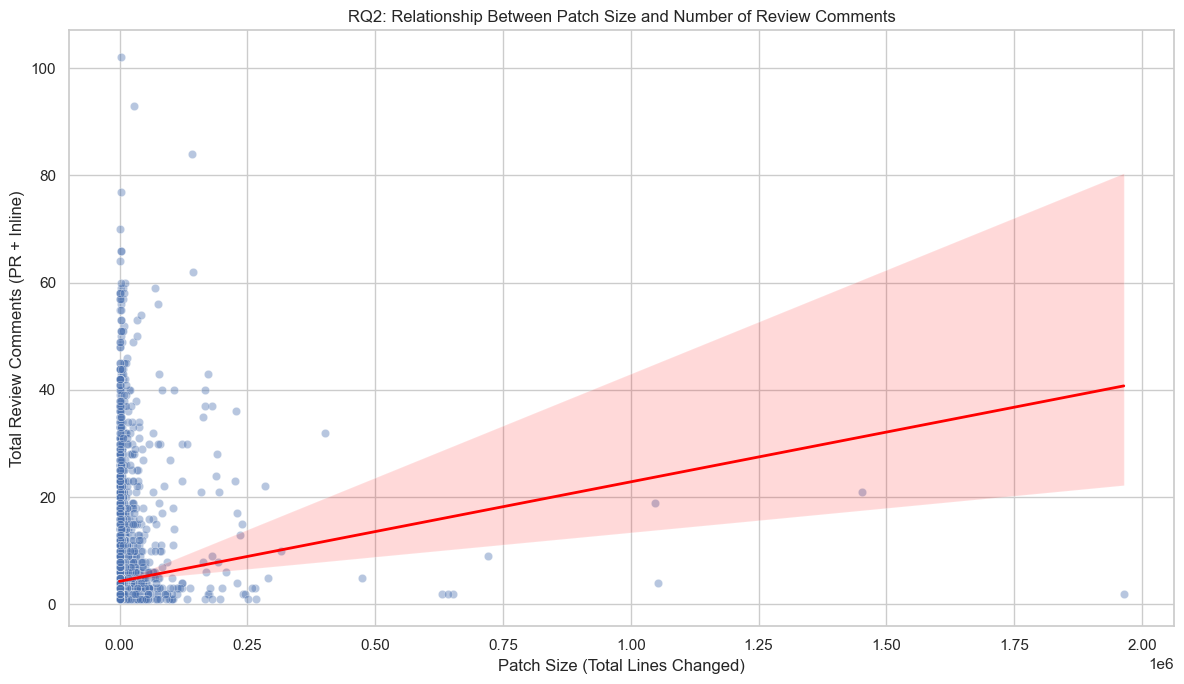

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

base = "hf://datasets/hao-li/AIDev/"

# -------------------------------------------------------
# 1. Load all relevant tables
# -------------------------------------------------------
commit_details = pd.read_parquet(base + "pr_commit_details.parquet")
pr_comments = pd.read_parquet(base + "pr_comments.parquet")
pr_review_comments = pd.read_parquet(base + "pr_review_comments.parquet")
pr_reviews = pd.read_parquet(base + "pr_reviews.parquet")

print("Tables loaded successfully.")


# -------------------------------------------------------
# 2. Patch size per PR (sum of additions/deletions/changes)
# -------------------------------------------------------
patch_df = (
    commit_details.groupby("pr_id")
    .agg(
        total_additions=("additions", "sum"),
        total_deletions=("deletions", "sum"),
        total_changes=("changes", "sum"),
    )
    .reset_index()
)

patch_df["patch_size"] = patch_df["total_changes"]


# -------------------------------------------------------
# 3A. PR comments (general discussion thread)
# -------------------------------------------------------
pr_comment_counts = (
    pr_comments.groupby("pr_id")["id"]
    .count()
    .reset_index()
    .rename(columns={"id": "num_pr_comments"})
)


# -------------------------------------------------------
# 3B. Review comments (inline review comments)
# Need to map pr_review_comments.pull_request_review_id -> pr_reviews.id
# -------------------------------------------------------

# Merge review comments with the review metadata to recover pr_id
review_comments_with_pr = pd.merge(
    pr_review_comments,
    pr_reviews[["id", "pr_id"]],           # only need review_id + pr_id
    left_on="pull_request_review_id",
    right_on="id",
    how="left"
)

review_comment_counts = (
    review_comments_with_pr.groupby("pr_id")["pull_request_review_id"]
    .count()
    .reset_index()
    .rename(columns={"pull_request_review_id": "num_review_comments"})
)


# -------------------------------------------------------
# 4. Combine all comments into a single count
# -------------------------------------------------------
comment_df = pd.merge(
    pr_comment_counts,
    review_comment_counts,
    on="pr_id",
    how="outer"
).fillna(0)

comment_df["total_comments"] = (
    comment_df["num_pr_comments"] +
    comment_df["num_review_comments"]
)


# -------------------------------------------------------
# 5. Combine patch size with comment counts
# -------------------------------------------------------
rq2_df = pd.merge(
    patch_df,
    comment_df[["pr_id", "total_comments"]],
    on="pr_id",
    how="inner"
)

print("Merged RQ2 dataset:")
display(rq2_df.head())


# -------------------------------------------------------
# 6. Correlation analysis
# -------------------------------------------------------
pearson_corr = rq2_df["patch_size"].corr(rq2_df["total_comments"], method="pearson")
spearman_corr = rq2_df["patch_size"].corr(rq2_df["total_comments"], method="spearman")

print(f"Pearson correlation:  {pearson_corr:.4f}")
print(f"Spearman correlation: {spearman_corr:.4f}")


# -------------------------------------------------------
# 7. Linear regression: comments ~ patch_size
# -------------------------------------------------------
slope, intercept, r_value, p_value, std_err = stats.linregress(
    rq2_df["patch_size"],
    rq2_df["total_comments"]
)

print("\nLinear Regression Results:")
print(f"  Slope:      {slope:.4f}")
print(f"  Intercept:  {intercept:.4f}")
print(f"  R-squared:  {r_value**2:.4f}")
print(f"  P-value:    {p_value:.4e}")


# -------------------------------------------------------
# 8. Scatterplot with regression line
# -------------------------------------------------------
plt.figure(figsize=(12, 7))

sns.scatterplot(
    data=rq2_df,
    x="patch_size",
    y="total_comments",
    alpha=0.4
)

sns.regplot(
    data=rq2_df,
    x="patch_size",
    y="total_comments",
    scatter=False,
    color="red",
    line_kws={"linewidth": 2}
)

plt.title("RQ2: Relationship Between Patch Size and Number of Review Comments")
plt.xlabel("Patch Size (Total Lines Changed)")
plt.ylabel("Total Review Comments (PR + Inline)")
plt.tight_layout()
plt.show()